## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *

from torchsampler import ImbalancedDatasetSampler

In [2]:
torch.manual_seed(809)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
                          RandomResizedCrop((size,size),scale=(0.8,1),ratio=(0.9,1.1)),

## Prepare Dataset

In [4]:
def create_subsets(root, transformation):
    dataset = ImageFolder(root, transformation)
    train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
    return train, test, val

In [5]:
def produce_loaders(train, test, val):
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_loader, test_loader, valid_loader

In [6]:
size = 44
batch_size = 32
transformation = Compose([RandomHorizontalFlip(), 
                          Resize((size, size)), ToTensor()])

In [8]:
root = 'expanded_dataset/cropped_not_aug'
train_data, test_data, val_data = create_subsets(root, transformation)
train_loader, test_loader, val_loader = produce_loaders(train_data, test_data, val_data)

[732, 616, 1141, 755, 184, 1079, 439, 779, 166]


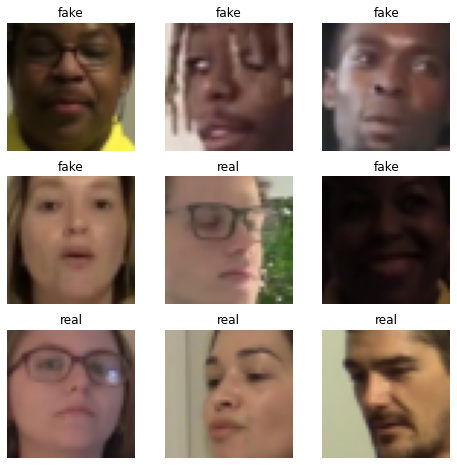

In [9]:
visualize_data(train_data)

[0, 85, 13, 9, 41, 41, 7, 49, 25]


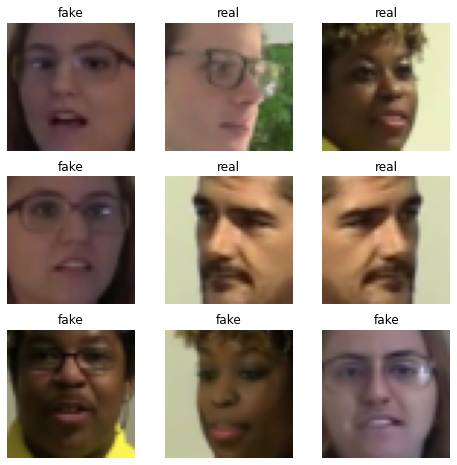

In [10]:
visualize_data(test_data)

## Initialize Model

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
from math import floor
# number of hidden layers and their sizes
hidden = [3, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [13]:
model = DeepSearch(hidden=hidden, kernel_size=kernel_size,
                   window=window, hidden_linear=hidden_linear).to(device)
model.load_state_dict(torch.load("./DeepSearch_checkpoint")["model_state_dict"])
print(model)

DeepSearch(
  (conv_combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear_combined): Sequential(
    (0): DeepSearchLinear(
      (linear): Linear(in_features=23104, out_features=512, bias=True)
      (batch_norm): BatchN

## Training Model

In [13]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [14]:
optimizer = create_adam_optimizer(model, lr=0.001)
#optimizer.load_state_dict(torch.load("./DeepSearch2_15epochs")["optimizer_state_dict"])

In [15]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.5
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.5651041666666666
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.6136363636363636
--- Epoch 1/20: Train loss: 0.6957, Train accuracy: 0.6078
--- Epoch 1/20: Val loss: 0.5272, Val accuracy: 0.8529
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.75
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.7083333333333334
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.7230113636363636
--- Epoch 2/20: Train loss: 0.6110, Train accuracy: 0.7145
--- Epoch 2/20: Val loss: 0.5619, Val accuracy: 0.7157
Epoch 3/20, Batch number: 0, Cumulated accuracy: 0.75
Epoch 3/20, Batch number: 5, Cumulated accuracy: 0.7604166666666666
Epoch 3/20, Batch number: 10, Cumulated accuracy: 0.7315340909090909
--- Epoch 3/20: Train loss: 0.5591, Train accuracy: 0.7255
--- Epoch 3/20: Val loss: 0.5277, Val accuracy: 0.7647
Epoch 4/20, Batch number: 0, Cumulated accuracy: 0.671875
Epoch 4/20, Batch number: 5,

## Testing Model & Performance Curves

In [14]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.1932, Test accuracy: 0.9130


Precision: 0.9117647058823529
Recall: 0.9117647058823529
F1 score: 0.9117647058823528


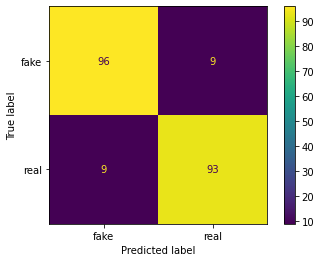

In [15]:
show_metrics(true_labels, model_preds)

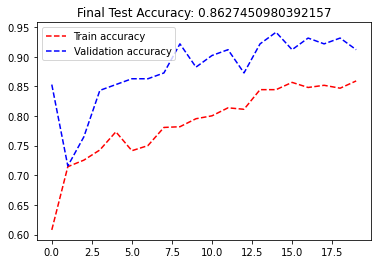

In [18]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

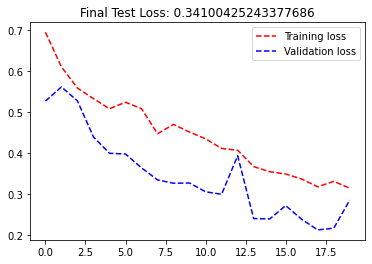

In [19]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [20]:
test_loader2 = produce_loader(test_data, 1)

In [21]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.8571428571428571
Recall: 0.8181818181818182
F1 score: 0.8372093023255814


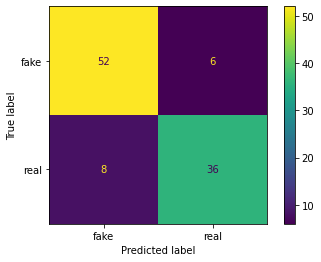

In [22]:
show_metrics(true_labels2, model_preds2)

[44, 50, 52, 47, 85, 71, 46, 29, 76, 82, 87, 6, 54, 17, 22, 8, 35, 24, 5, 40, 38, 73, 37, 17, 62]


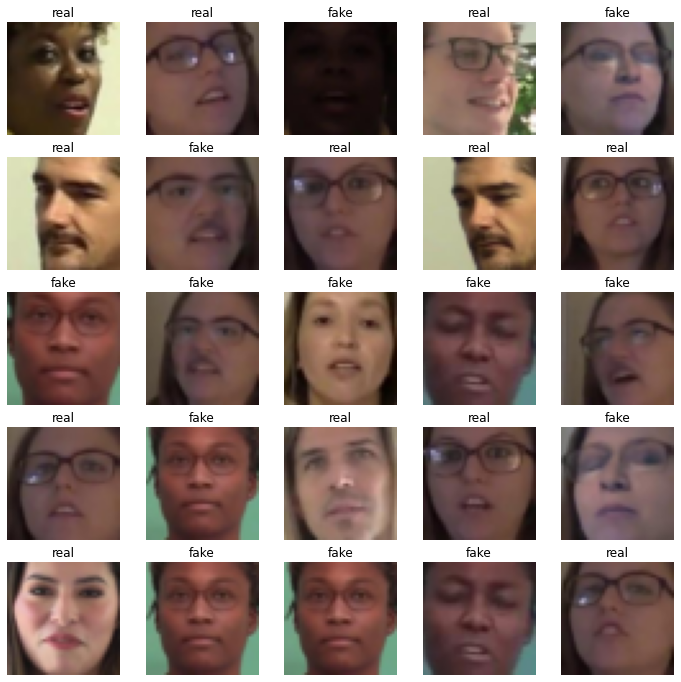

In [23]:
visualize_data(correct_list, (12,12), 5)

[10, 5, 8, 0, 10, 0, 12, 11, 11, 9, 2, 8, 13, 2, 11, 4, 5, 7, 4, 5, 2, 0, 8, 11, 12]


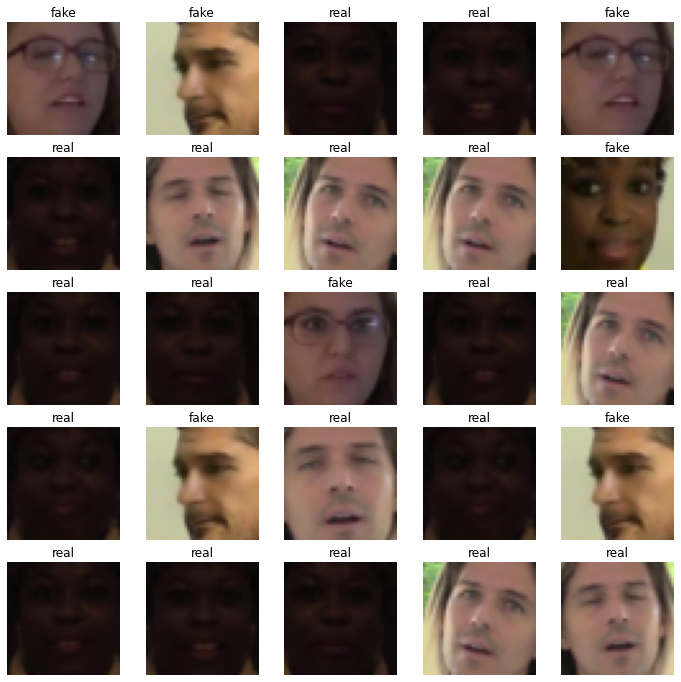

In [24]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './DeepSearch_19epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])